# Projet CENSE

In [1]:
# Try listening
import librosa.display
import IPython.display as ipd

# Feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

# Show the rate of progressing
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [22]:
path = '.\TUT-acoustic-scenes-2017-development.meta\TUT-acoustic-scenes-2017-development'
fold1 = os.listdir(path)
meta = os.path.join(path,fold1[1])   # meta file
label = []
with open(meta, 'r') as f:
    data = f.readlines()  #data reading line by line
    for line in data:
        record = line.split()        #split the filename and label
        label.append(record[1])

L = {}
for key in label:
    L[key] = L.get(key, 0) + 1
print('Total number in aeach group')
for key in L.keys():
    print(key,':',L.get(key,0))

Total number in aeach group
beach : 312
bus : 312
cafe/restaurant : 312
car : 312
city_center : 312
forest_path : 312
grocery_store : 312
home : 312
library : 312
metro_station : 312
office : 312
park : 312
residential_area : 312
train : 312
tram : 312


# préprocessing

In [23]:
np.random.seed(43)
file_path = '.\TUT-acoustic-scenes-2017-development.meta\TUT-acoustic-scenes-2017-development\evaluation_setup'
fold1 = os.listdir(file_path)[0:3]
print('evaluate set is', fold1[0])
print('test set is', fold1[1])
print('train set is', fold1[2])

evaluate set is fold1_evaluate.txt
test set is fold1_test.txt
train set is fold1_train.txt


In [24]:
train = os.path.join(file_path,fold1[2])
fold1_filename_train = []
fold1_label_train = []
with open(train, 'r') as f:
    data = f.readlines()  #data reading line by line
    for line in data:
        record = line.split()        #split the filename and label
        fold1_filename_train.append(record[0][6:])
        fold1_label_train.append(record[1])
nb_train = len(fold1_filename_train)
print('In fold 1 there are {} sounds to train'.format(nb_train))

In fold 1 there are 3510 sounds to train


Because training set is too large, so we can take out some songs for testing our method

In [25]:
audio_train = []

indices = np.arange(nb_train)
np.random.shuffle(indices)
# n_sound = len(fold1_filename_train)  # select some data to have a try, otherwise we consider the whole data set
n_sound = 1000  # choose a subset of the total set to try
indices = indices[:n_sound]
fold1_filename_train = np.array(fold1_filename_train)[indices]
fold1_label_train = np.array(fold1_label_train)[indices]

for root,dirnames,filenames in os.walk('./'):
    for filename in filenames:
         if filename in fold1_filename_train:
            f = os.path.join(root, filename)
            audio_train.append(f)
print(f'training set has {len(audio_train)} data')
print(f'training set label has {len(fold1_label_train)} records')
classes_train = set(fold1_label_train)  # find the unique elements
n_classes_train = len(classes_train)
print(f'There are {n_classes_train} classes in the training set')

training set has 1000 data
training set label has 1000 records
There are 15 classes in the training set


In [26]:
Label = dict(zip(classes_train, list(np.arange(n_classes_train))))  # build the connection between labels and numbers
print('label list :\n')
for (k,v) in Label.items():
    print("%s = "%k,v)
temp=[]
for label in fold1_label_train:
    temp.append(Label[label])
fold1_label_train= temp

label list :

home =  0
cafe/restaurant =  1
forest_path =  2
park =  3
car =  4
beach =  5
residential_area =  6
library =  7
grocery_store =  8
tram =  9
metro_station =  10
train =  11
bus =  12
city_center =  13
office =  14


Signal in the time domain

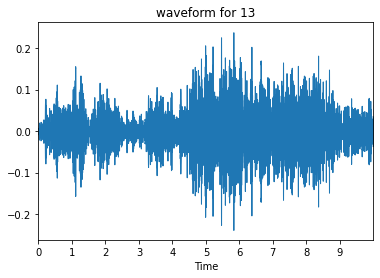

In [27]:
n = 2
song = audio_train[n]
y, sr = librosa.load(song, mono=True)    # original audio file lasts for 10 seconds
librosa.display.waveplot(y, sr=sr)
plt.title('waveform for {}'.format(fold1_label_train[n]))
plt.show()
ipd.Audio(audio_train[2])

Show the Mel filter matrix

(40, 1025)


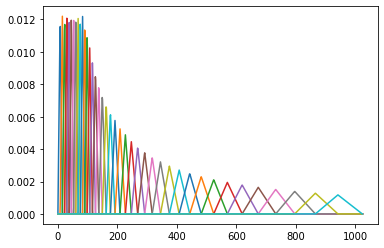

In [29]:
melfb = librosa.filters.mel(sr=22050, n_fft = 2048, n_mels = 40, fmin=0, fmax=sr/2)
# melfb /= np.max(melfb,axis=-1)[:,None]
print(melfb.shape)
# librosa.display.specshow(melfb, x_axis='linear')
idxs_to_plot = np.arange(40)
for i in idxs_to_plot:
    plt.plot(melfb[i])

It takes a lot of time to calculate the MFCC coefficients of traning set, ***30 min*** to load 3510 sound files

In [ ]:
%%time

# MFCC is a matrix who stores the MFCC coefficients of each audio

if os.path.exists('MFCC.npy'):
    MFCC = np.load('MFCC.npy')
else:
    MFCC = np.zeros((n_sound,20,431))
    i = 0
    for song in tqdm(audio_train, position=0):
        y, sr = librosa.load(song, mono=True)    # original audio file lasts for 10 seconds
        MFCC[i,:,:]= librosa.feature.mfcc(y=y, sr=sr)    # 20 * 431
        i+=1
    np.save('MFCC.npy',MFCC)
print('MFCC shape is ',MFCC.shape)  #  (n_sound, 20, 431)

If necessary, we could add other features in the feature vector.

In [ ]:
%%time

if os.path.exists('feature.npy'):
    feature = np.load('feature.npy')
else:
    feature = np.zeros((n_sound,29,431))
    i = 0
    for song in tqdm(audio_train, position=0):
        y, sr = librosa.load(song, mono=True)    # original audio file lasts for 10 seconds
        
        chroma_stft = librosa.feature.chroma_stft (y=y,sr=sr)  # 12*431
        chroma_cqt = librosa.feature.chroma_cqt (y=y,sr=sr)  # 12*431
        rmse = librosa.feature.rms(y=y)   # 1*431
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)   # 1*431
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)    # 1*431
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr) # 1*431
        zcr = librosa.feature.zero_crossing_rate(y) # 1*431
        feature[i,:,:] = np.vstack((chroma_stft, chroma_cqt, rmse, spec_cent, spec_bw, rolloff, zcr))
        i+=1
    np.save('feature.npy',feature) 
print('feature shape is ',feature.shape)

# fenêtre de texture

In [32]:
def dist(x,y,choix):
    """  x and y should be vectors """
    
    x_ = (x-np.mean(x))/np.std(x)
    y_ = (y-np.mean(y))/np.std(y)
    if choix == "euclidian":
        return(np.linalg.norm(x_-y_))
    elif choix=="cosine":
        return(1- np.vdot(x_,y_)/np.linalg.norm(x_)/np.linalg.norm(y_))
    
# x and y are feature matrix, the function will calculate the temporal mean MFCC coefficients
def dist_moy(x,y,choix):
    """x et y sont des matrices de MFCC. On calcule la distance entre x et y en faisant la 
    moyenne de chaque dans les matrices puis on regarde la distance entre les deux vecteurs de moyennes."""
    
    xbarre = np.mean(x,axis=1)
    ybarre = np.mean(y,axis=1)
    output = dist(xbarre,ybarre,choix)
    return(output)

def wind_texture(M,wsize):
    """Calcul les moyennes temporelles des fenêtres de textures dans une matrice de MFCC.

    M : Matrice de MFCC au format Quefrence x temps
    wsize : Nombre de trames retenues dans la fenêtre"""

    # n est le nombre de caractéristiques, m est la nombre de trame
    n,m = M.shape
    nwind = m//wsize
    
    W = np.zeros((n,nwind))
    
    for i in range (nwind):
        W[:,i] = np.mean(M[:,i*wsize:(i+1)*wsize],axis=1)
    
    return(W)

def dist_wind(A,B,choix,wsize):
    """La distance entre A et B correspond à la distance entre les deux fenêtres les plus proches.
    
    A,B : Matrices de MFCC
    choix : distance euclidienne ou cosinus"""
    
    x = wind_texture(A,wsize)
    y = wind_texture(B,wsize)
    
    n,m = np.shape(x)
    distxy = np.zeros((m,1))
    
    for k in range(m):
        distxy[k] = dist(x[:,k],y[:,k],choix)
    return(np.min(distxy))
#     return(distxy[np.where(distxy==min(distxy))[0][0]])

def p_at_k_index(μ_um,k):
    " For a certain cluster centroide in the matrix windowed MFCC, return the index which indicates the k nearest neighbors"

    d,m = μ_um.shape
    dist_mat = np.zeros((m,m))
    index = np.zeros((m,m-1)).astype(np.int)
    for i in range(m):
        for j in range(i,m):
            dist_mat[i,j] = dist(μ_um[:,i],μ_um[:,j],'euclidian')
            dist_mat[j,i] = dist_mat[i,j]
    for k in range(m):
        D = dist_mat[k,:]
        index[k,:] = np.argsort(np.ravel(D))[1:]  # from small to big except itself
    return index

In [ ]:
# Normalization on each segment of MFCC matrix
N_train = len(audio_train)
data_train = MFCC[:,1:,:]   # eliminate the first MFCC coefficient which indicates the energy of each segment
data_train_norm = np.zeros(np.shape(data_train))
for i in range(N_train):
    data_ = data_train[i,:,:].T
    data_train_norm[i,:,:] = ((data_- np.mean(data_,axis=0))/np.std(data_,axis=0)).T
print('training data format: ',data_train_norm.shape)

# RBF methods

In [497]:
def RBF(M, u, v, wsize = 43, K=5, type = 'RBQ-c'):
    """
    Input:
    M: MFCC matrix which represent all scenes in the training set
    u,v: u-th and v-th scene index,respectively which we will analyze
    mat_dist: distance between every two scenes in the M matrix 
    labels: scene type in the M matrix
    K: number of nearest neighbors
    type: kernel type
    
    Output:
    similarity:  similarity between the scene centroids over the entire dataset
    
    Attention:
    1.Here, μ_um_q and μ_vn_q are the q-th nearest neighbors to the centroids μ_um and μ_vn, respectively
    2.By default the Euclidean norm is to be used.
    3.Three types to be selected: RBQ-c, RBQ-a, RBQ-w, by default RBQ-c
    4.By default we consider K-nearest neignbors K=5
    """
    U = M[u,:,:]   # feature matrix of each scene
    V = M[v,:,:]
    
    μ_um = wind_texture(U,wsize)  # window filtered feature matrix 
    μ_vn = wind_texture(V,wsize)
    
    d,m = μ_um.shape   # after window, d: feature number; m,n: segment number, m=n
    d,n = μ_vn.shape
    
    u_knn = p_at_k_index(μ_um,K)  # index
    v_knn = p_at_k_index(μ_vn,K)
    
    K_mn = np.zeros((K,m,n)) # K nearest neighbors->K elements

    for q in range(K):
        for mm in range(m):
            for nn in range(n):
                UM = μ_um[:,mm]
                VN = μ_vn[:,nn]
                UMQ = μ_um[:,u_knn[mm,q]]  # q-th nearest neighbors for μ_um
                VNQ = μ_vn[:,v_knn[nn,q]]
                
                num = np.linalg.norm(UM - VN)
                den = np.linalg.norm(UM - UMQ)*np.linalg.norm(VN - VNQ)
                R = num**2 / den
                K_mn[q,mm,nn] = np.exp(-R)
        
    if type=='RBQ-c':
        temp = np.max(K_mn,axis = 1)
        similarity = np.max(temp,axis = 1)
    elif type == 'RBQ-a':
        temp = np.mean(K_mn,axis = 1)
        similarity = np.mean(temp,axis = 1)
    elif type == 'RBQ-w':
        # Suppose in the matrix μ_um there are M columns so there will be M clusters, then M centroids
        # Each of the M centroids μu1, . . . , μuM are paired with corresponding weights wu1, . . . , wuM
        # The weight wum for the m-th centroid μum is the number of frames belonging to a particular cluster
        # Since wh use the windows with equal length so the weight is the same for each columm
        w = np.ones((K,m,n))/(m*n)
        temp = np.sum(K_mn*w,axis=1)
        similarity = np.sum(temp,axis=1)
    else:
        return(print('Wrong type!'))
    return(similarity)

In [545]:
# test using data_train_norm, which eliminates the first coefficient
RBF(data_train_norm, 1, 2, wsize=43, K= 8, type = 'RBQ-c')

array([0.56489566, 0.61105084, 0.57439741, 0.88768014, 0.87210636,
       0.91949379, 0.94431003, 0.94580409])

In [ ]:
# matrix rbf shows the similarity between every two scene in the training set--need a lot of time

from tqdm import tqdm

K= 8   # number of nearest neighbors
nb_train = len(audio_train)
rbf = np.zeros((nb_train,nb_train,K))
for u in tqdm(range(nb_train), position=0):
    for v in range(u,nb_train):
        rbf[u,v,:] = RBF(data_train_norm,u,v, wsize = 43,K = K, type = 'RBQ-c')
        rbf[v,u,:] = rbf[u,v,:]

In [ ]:
def precision_similarity(mat_sim, k, labels):   # k plus grande similarity
    # mat_sim is a square matrix
    
    N = np.shape(mat_sim)[0]
    prec = np.zeros(N)
    for t in range(N):
        sim = mat_sim[t,:]
        simsort = np.argsort(sim)
        simsort = simsort[::-1]  #  descendant
        prec[t] = np.sum(labels[t] == labels[simsort[i]] for i in range(1,k+1))/k

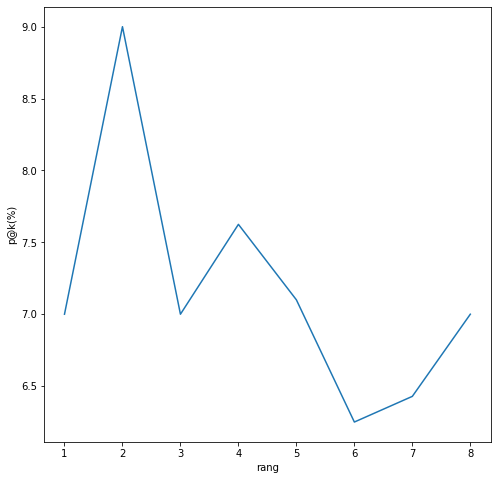

In [609]:
# precision_similarity(rbf, 10, fold1_label_train)
precision = np.zeros((200,8))
k = 8
labels = fold1_label_train
for i in range(1,k+1):
    mat_sim = rbf[:,:,i-1]
    N = np.shape(mat_sim)[0]
    prec = np.zeros(N)
    for t in range(N):
        sim = mat_sim[t,:]
        simsort = np.argsort(sim)
        simsort = simsort[::-1]
        prec[t] = np.sum(labels[t] == labels[simsort[v]] for v in range(1,i+1))/i
    precision[:,i-1] = prec
prec_moy = np.mean(precision,axis=0)
plt.figure(figsize=(8,8))
plt.plot([1,2,3,4,5,6,7,8],100*prec_moy)
plt.xlabel('rang')
plt.ylabel('p@k(%)')
plt.show()

In [305]:
test = os.path.join(file_path,fold1[0])
fold1_filename_test = []
fold1_label_test = []

with open(test, 'r') as f:
    data = f.readlines()  #data reading line by line
 
    for line in data:
        record = line.split()        #split the filename and label
        fold1_filename_test.append(record[0][6:])
        fold1_label_test.append(record[1])
print('fold 1 has {} documents to test'.format(len(fold1_filename_test)))


fold 1 has 1170 documents to test


In [306]:
audio_test = []

for root,dirnames,filenames in os.walk('./'):
    for filename in filenames:
         if filename in fold1_filename_test:
            f = os.path.join(root, filename)
            audio_test.append(f)

print(f'Test set has {len(audio_test)} records')
classes_test = set(fold1_label_test)
n_classes_test = len(classes_test)
print(f'There are {n_classes_test} classes in the test set')

Test set has 1170 records
There are 15 classes in the test set


In [307]:
temp=[]
for label in fold1_label_test:
    temp.append(dictionary[label])
fold1_label_test= temp

It takes a lot of time to calculate the MFCC coefficients of test set, about 11m 7s to finish the calculation.

In [308]:
%%time
# M_test is a matrix who stores the MFCC infomation about each test audio

if os.path.exists('M_test.npy'):
    M_test = np.load('M_test.npy')
else:
    M_test = np.zeros((len(audio_test),20,431))
    i = 0
    for song in audio_test:
        y, sr = librosa.load(song, mono=True) 
        M_test[i,:,:] = librosa.feature.mfcc(y=y, sr=sr)
        i+=1 
    np.save('M_test.npy',M_test)   

Wall time: 1.26 s


In [309]:
# Normalization on each segment of MFCC matrix

N_test = len(audio_test)
data_test = M_test[:,1:,:]  # eliminate the first MFCC coefficient which indicates the energy of each segment
data_test_norm = np.zeros(np.shape(data_test))

for i in range(N_test):
    data_ = data_test[i,:,:].T
    data_test_norm[i,:,:] = ((data_-np.mean(data_,axis=0))/np.std(data_,axis=0)).T
print('test data format: ',data_test_norm.shape)


test data format:  (1170, 19, 431)


# Other unsupervised methode of clustering 

In [ ]:
from sklearn.model_selection import train_test_split
X, y = np.mean(data_train_norm,axis=2), np.array(fold1_label_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)
print ('successfully splitted')

## Random Forest Classifier

In [469]:
from sklearn.ensemble import RandomForestClassifier
import time

t0 = time.time()

clf = RandomForestClassifier(n_estimators = 100, criterion='gini')
clf.fit(X_train, y_train)
t1 = time.time()
print ('time elapsed for fitting: ', t1-t0)
print ('done fitting')

print ('fit to train new: ', clf.score(X_train, y_train))
print ('fit to test: ', clf.score(X_test, y_test))

# print(clf.feature_importances_)
XX = np.mean(data_train_norm,axis=2)
sum = []
for t in range(200):
    sum.append(clf.predict( [XX[t,:]])==fold1_label_train[t])
print('accuracy is ',np.sum(sum)/200)

time elapsed for fitting:  0.6611378192901611
done fitting
fit to train new:  0.06875
fit to test:  0.09
accuracy is  0.055


## KMeans

In [478]:
from sklearn.model_selection import train_test_split
X, y = np.mean(data_train_norm,axis=2), np.array(fold1_label_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)
print ('successfully splitted')

successfully splitted


In [480]:
from sklearn.cluster import KMeans

n_clusters = 15
km = KMeans(n_clusters=n_clusters,max_iter=300,tol=1e-4,n_jobs=-1,random_state=42,)
km.fit(X_train)
np.sum(km.labels_== y_train)/np.size(y_train)

0.08375

## PCA+KNN

In [481]:
from sklearn.model_selection import train_test_split
X, y = np.mean(data_train_norm,axis=2), np.array(fold1_label_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)
print ('successfully splitted')

successfully splitted


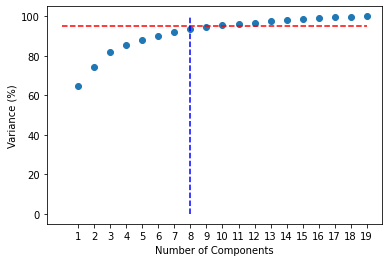

In [482]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)

plt.scatter(np.arange(1,20),100*np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.hlines(95, 0, 19, colors='r', linestyles = 'dashed')
plt.vlines(8,0,100, colors = 'b', linestyles = 'dashed')
plt.xticks(np.arange(1,20)) 
plt.show()

In [483]:
pca = PCA(n_components=8)
pca.fit(X_train)
X_train = pca.fit_transform(X_train, y = y_train)
X_test = pca.fit_transform(X_test)
y_train = y_train
y_test = y_test

In [487]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.05